In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry.polygon import LinearRing
from shapely.geometry import box, Polygon
import time
from shapely.geometry import asPoint
import shapely.wkt
import matplotlib.pyplot as plt

In [2]:
def VBOCleaner(data):
    print(data.shape)
    
    # only keep objects with id
    data = data[data["identificatie"].notna()]
    print(data.shape)
    
    # only keep objects which are currently in use # CHECK of dit de juiste zijn
    data = data[data.verblijfsobjectStatus.isin(["Verblijfsobject gevormd", 
                                                 "Verblijfsobject in gebruik",
                                                 "Verblijfsobject in gebruik (niet ingemeten)"])]
    data = data[data.pos.notna()]
    print(data.shape)
    
    data["begindatumTijdvakGeldigheid"] =  pd.to_datetime(data['begindatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    data["einddatumTijdvakGeldigheid"] =  pd.to_datetime(data['einddatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    
    def toPoint(pos):
        return asPoint([float(i) for i in pos.split()[:2]])
    data["pos"] = data.pos.apply(toPoint)
    
    return data

In [3]:
# # Load neccessary datasets
vierkant = gpd.read_file("../Data/NLvierkant/NL_vierkant100m.shp")
df = pd.read_csv("woonplaats_grenzen.csv" , sep = ";")
vbo = pd.read_csv("VBO.csv", sep = ";", encoding = "utf-8", na_values = "NaN", on_bad_lines = "warn")
vbo = VBOCleaner(vbo)

(19501545, 7)
(18918593, 7)
(18386142, 7)


In [4]:
class city_grid():
    def __init__(self, city_borders, grid, city):
        
        # Select only the city_borders of wanted city and transform geometry (string) to geometry object
        self.city_borders = city_borders[city_borders.woonplaats.str.contains(city)]
        self.city_borders.geometry = self.city_borders.geometry.apply(shapely.wkt.loads)
        
        self.grid = grid
        self.city = city
        self.union = LinearRing()
        self.df = gpd.GeoDataFrame()
    
    def border_fix(self, name = "name", loc = "loc"):
        if name != "name":
            self.city_borders =  self.city_borders[~self.city_borders.woonplaats.str.contains(name)]
        elif loc != "loc":
            self.city_borders = self.city_borders.drop(loc)
    
    def print_borders(self):
        print(self.city_borders)
    def create_union(self):
        for _, i in self.city_borders.iterrows():
            if not i.geometry.is_empty:
                x, y = i.geometry.xy
                self.union = self.union.union(i.geometry)
                plt.plot(x, y)
        plt.show()
        
    def create_grid(self):

        def create_box(bounds, distance):
            xmin, ymin, xmax, ymax = bounds
            xmin -= distance
            ymin -= distance
            xmax += distance
            ymax += distance

            return xmin, ymin, xmax, ymax

        boundbox = box(*create_box(self.union.bounds, 100))
             
        tot = len(self.grid)
        for i, v in self.grid.iterrows():
            print("{0:.1f}%".format((i / tot) * 100), end = "\r")
            if boundbox.contains(v.geometry):
                self.df = self.df.append(v)
                
    def join_vbo(self, vbo):
        print("joining {} to vbo's".format(self.city))
        vbopoints = gpd.GeoDataFrame(vbo, geometry = "pos")
        grid = self.df
#         grid['geometry'] = grid.geometry.apply(shapely.wkt.loads) # load geometry as shape
        grid = gpd.GeoDataFrame(grid)
        print(grid.shape)
        # join each cbs row with a vbo that contains a vbo point
        self.vbo_grid = gpd.tools.sjoin(vbopoints, grid, op = "within")

        
    def save_grid(self):
        self.df.to_csv("../Data/presnap/grid/" + self.city + "_grid.csv")
        self.vbo_grid.to_csv("../Data/presnap/vbo/" + self.city + "_vbo.csv")

In [ ]:
with open("lists/to_grid.txt", "r+") as f:
    print("hi")
    while True:
        print("hi")
        city = f.readline().strip("\n")
        print(city)
        if city == "":
            break
        else:
            cg = city_grid( df, vierkant, city)
            cg.create_union()
            cg.create_grid()
            cg.join_vbo(vbo)
            cg.save_grid()
            

C:\Users\Gebruiker\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


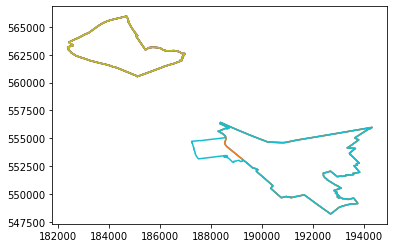

In [13]:
cg = city_grid( df, vierkant, "Heerenveen")
cg.create_union()


In [16]:
cg.city_borders

,woonplaats,geometry
3581,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3582,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3583,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3584,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3585,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3586,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3587,Heerenveen,"LINEARRING (182458.476 563558.647, 182461.194 ..."
3588,Heerenveen,"LINEARRING (191050.238 549728.535, 191086.414 ..."


In [15]:
cg.border_fix(loc = [1747,1748])

In [17]:
cg.create_grid()

In [18]:
cg.join_vbo(vbo)

joining Heerenveen to vbo's
(21538, 2)


In [19]:
cg.save_grid()

In [22]:
cg.city

'Tilburg'

In [17]:
x, y = cg.geometry.xy
plt.plot(x, y)
xbox, ybox = box(*create_box(cg.geometry.bounds, 1000)).exterior.xy

plt.plot(xbox, ybox)

AttributeError: 'city_grid' object has no attribute 'geometry'